# ehrMGAN: Electronic Health Records Multiple Generative Adversarial Networks
This notebook implements the complete ehrMGAN model for generating synthetic electronic health records data. The model combines VAEs and GANs to generate both continuous (vital signs) and discrete (medications/interventions) time series data.

## 1. Environment Setup
First, let's set up our environment with the necessary imports and check the configuration.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories if they don't exist
os.makedirs("data/checkpoint/", exist_ok=True)
os.makedirs("data/fake/", exist_ok=True)
os.makedirs("logs/", exist_ok=True)

# Environment information
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages

TensorFlow version: 1.14.0
NumPy version: 1.19.5
Pandas version: 1.1.5


In [2]:
import platform
import psutil
import GPUtil

# System info
print(f"System: {platform.system()} {platform.version()}")
print(f"Python version: {platform.python_version()}")
print(f"Processor: {platform.processor()}")

# Memory info
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")

# GPU info
try:
    gpus = GPUtil.getGPUs()
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}, Memory: {gpu.memoryTotal} MB")
            print(f"   Memory used: {gpu.memoryUsed} MB, Load: {gpu.load*100:.1f}%")
    else:
        print("No GPU detected")
except:
    print("Could not detect GPU information")

# Check if TensorFlow sees GPUs
print("\nTensorFlow GPU availability:")
print(f"GPU available: {tf.test.is_gpu_available()}")

System: Windows 10.0.19041
Python version: 3.6.15
Processor: AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
Total memory: 31.93 GB
Available memory: 22.41 GB
GPU 0: NVIDIA GeForce RTX 3060, Memory: 12288.0 MB
   Memory used: 767.0 MB, Load: 12.0%

TensorFlow GPU availability:
GPU available: False


### 2. Import Model Components
Now let's import the necessary model components from our files.

In [3]:
# Import the model components
import sys
sys.path.append('.')

# Let's first import the necessary modules
from networks import C_VAE_NET, D_VAE_NET, C_GAN_NET, D_GAN_NET
from m3gan import m3gan
from utils import renormlizer
from visualise import visualise_gan, visualise_vae

### 3. Data Loading and Preprocessing
Let's load and preprocess the data.

In [4]:
# Data parameters
patinet_num = 16062
filename_postfix = '5_var'

# Load continuous data (vital signs)
continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
continuous_x = continuous_x.reshape(patinet_num, 24, 5)
print(f"Continuous data shape: {continuous_x.shape}")

# Load discrete data (medications/interventions)
discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
discrete_x = discrete_x.reshape(patinet_num, 24, 1)
print(f"Discrete data shape: {discrete_x.shape}")

# Load static data (patient demographics)
statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])
print(f"Static labels shape: {statics_label.shape}")

# Data statistics
print("\nContinuous data statistics:")
print(f"Mean: {np.mean(continuous_x, axis=(0,1))}")
print(f"Std: {np.std(continuous_x, axis=(0,1))}")
print(f"Min: {np.min(continuous_x, axis=(0,1))}")
print(f"Max: {np.max(continuous_x, axis=(0,1))}")

print("\nDiscrete data statistics:")
print(f"Mean: {np.mean(discrete_x)}")
print(f"Std: {np.std(discrete_x)}")
print(f"Min: {np.min(discrete_x)}")
print(f"Max: {np.max(discrete_x)}")

# Optional: Use a subset for faster experimentation
use_subset = False
subset_size = 5000
if use_subset:
    indices = np.random.choice(continuous_x.shape[0], subset_size, replace=False)
    continuous_x = continuous_x[indices]
    discrete_x = discrete_x[indices]
    statics_label = statics_label[indices]
    print(f"\nUsing subset of data: {subset_size} samples")

Continuous data shape: (16062, 24, 5)
Discrete data shape: (16062, 24, 1)
Static labels shape: (16062, 1)

Continuous data statistics:
Mean: [0.39582974 0.64002727 0.95716821 0.33487669 0.39307435]
Std: [0.07905853 0.17579326 0.05761428 0.18632828 0.12541822]
Min: [0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1.]

Discrete data statistics:
Mean: 0.5533661229402731
Std: 0.4971438996129025
Min: 0.0
Max: 1.0


### 4. Model Configuration and Hyperparameter Tuning
Let's define our hyperparameters based on the data dimensions.

In [5]:
# Configure hyperparameters based on data dimensions
time_steps = continuous_x.shape[1]  # 24 hours
c_dim = continuous_x.shape[2]       # 5 continuous features
d_dim = discrete_x.shape[2]         # 1 discrete feature
num_samples = continuous_x.shape[0] # Number of patients

# Latent space dimensions
# For complex data with higher dimensions, we need a larger latent space
shared_latent_dim = 15 
c_z_size = shared_latent_dim
c_noise_dim = max(2, int(c_dim/2))  # At least 2 dimensions
d_z_size = shared_latent_dim
d_noise_dim = max(1, int(d_dim/2))  # At least 1 dimension

# Network sizes - scale based on data complexity
batch_size = 1024  # Can be adjusted based on memory constraints
enc_dec_size = 128  # For 5 features, 128 is reasonable
enc_dec_layers = 2  # For 24 time steps, 2-3 layers is reasonable
gen_units = 256     # For generation quality
gen_layers = 2
disc_units = 128
disc_layers = 2
dropout_keep = 0.8  # 0.8 is typically good for medical data

# Learning rates - typically smaller for stable training
v_lr_pre = 0.0005   # VAE pretraining
v_lr = 0.0001       # VAE fine-tuning
g_lr = 0.0001       # Generator
d_lr = 0.0001       # Discriminator

# Training parameters
use_subset = True
if use_subset:
    num_pre_epochs = 6
    num_epochs = 10
else:
    num_pre_epochs = 300  # For 16K patients, 300 pre-epochs should be sufficient
    num_epochs = 500      # For GAN stability, 500 epochs should work well
d_rounds = 1          # Standard practice
g_rounds = 3          # Multiple generator updates per discriminator update
v_rounds = 1          # VAE updates

# Loss weights
alpha_re = 1.0    # Reconstruction weight (primary objective)
alpha_kl = 0.5    # KL divergence weight
alpha_mt = 0.2    # Matching weight (increased for better coordination)
alpha_ct = 0.2    # Contrastive weight (increased for feature learning)
alpha_sm = 1.0    # Semantic weight

# GAN loss weights
c_beta_adv = 1.0   # Adversarial weight for continuous
c_beta_fm = 10.0   # Feature matching for continuous (reduced to prevent mode collapse)
d_beta_adv = 1.0   # Adversarial weight for discrete
d_beta_fm = 10.0   # Feature matching for discrete (reduced for stability)

# Regularization
l2_scale = 0.001   # L2 regularization

# Conditional GAN parameters
conditional = False  # Whether to use conditional GAN
num_labels = 1 if conditional else 0  # Number of conditional labels

# Display configuration
print("Model Configuration:")
print(f"Latent dimensions - Continuous: {c_z_size}, Discrete: {d_z_size}")
print(f"Noise dimensions - Continuous: {c_noise_dim}, Discrete: {d_noise_dim}")
print(f"Batch size: {batch_size}")
print(f"Pre-training epochs: {num_pre_epochs}, Training epochs: {num_epochs}")
print(f"Network sizes - Encoder/Decoder: {enc_dec_size}, Generator: {gen_units}, Discriminator: {disc_units}")
print(f"Network layers - Encoder/Decoder: {enc_dec_layers}, Generator: {gen_layers}, Discriminator: {disc_layers}")
print(f"Learning rates - VAE pre: {v_lr_pre}, VAE: {v_lr}, Generator: {g_lr}, Discriminator: {d_lr}")

Model Configuration:
Latent dimensions - Continuous: 15, Discrete: 15
Noise dimensions - Continuous: 2, Discrete: 1
Batch size: 1024
Pre-training epochs: 6, Training epochs: 10
Network sizes - Encoder/Decoder: 128, Generator: 256, Discriminator: 128
Network layers - Encoder/Decoder: 2, Generator: 2, Discriminator: 2
Learning rates - VAE pre: 0.0005, VAE: 0.0001, Generator: 0.0001, Discriminator: 0.0001


### 5. Build Model Components
Now let's build the model components.

In [6]:
# For TF1.x compatibility
tf.reset_default_graph()

# Define the VAE and GAN networks
c_vae = C_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=c_dim,
    z_dim=c_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

c_gan = C_GAN_NET(
    batch_size=batch_size,
    noise_dim=c_noise_dim,
    dim=c_dim,
    gen_dim=c_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_vae = D_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=d_dim,
    z_dim=d_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_gan = D_GAN_NET(
    batch_size=batch_size,
    noise_dim=d_noise_dim,
    dim=d_dim,
    gen_dim=d_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

### 6. Create and Train the Model
Now let's set up the complete model and train it.

In [7]:
# Define checkpoint directory
checkpoint_dir = "data/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

# REPLACE the model building section (cell #6) with this:
# Reset the TensorFlow graph to avoid variable conflicts
tf.reset_default_graph()
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config=run_config)

# Create the complete M3GAN model
model = m3gan(
    sess=sess,
    batch_size=batch_size,
    time_steps=time_steps,
    num_pre_epochs=num_pre_epochs,
    num_epochs=num_epochs,
    checkpoint_dir=checkpoint_dir,
    epoch_ckpt_freq=100,  # Save checkpoint every 100 epochs
    epoch_loss_freq=1,   # Display loss every 10 epochs
    
    # Continuous parameters
    c_dim=c_dim,
    c_noise_dim=c_noise_dim,
    c_z_size=c_z_size,
    c_data_sample=continuous_x,
    c_vae=c_vae,
    c_gan=c_gan,
    
    # Discrete parameters
    d_dim=d_dim,
    d_noise_dim=d_noise_dim,
    d_z_size=d_z_size,
    d_data_sample=discrete_x,
    d_vae=d_vae,
    d_gan=d_gan,
    
    # Training parameters
    d_rounds=d_rounds,
    g_rounds=g_rounds,
    v_rounds=v_rounds,
    v_lr_pre=v_lr_pre,
    v_lr=v_lr,
    g_lr=g_lr,
    d_lr=d_lr,
    
    # Loss weights
    alpha_re=alpha_re,
    alpha_kl=alpha_kl,
    alpha_mt=alpha_mt,
    alpha_ct=alpha_ct,
    alpha_sm=alpha_sm,
    c_beta_adv=c_beta_adv,
    c_beta_fm=c_beta_fm,
    d_beta_adv=d_beta_adv,
    d_beta_fm=d_beta_fm,
    
    # Conditional parameters
    conditional=conditional,
    num_labels=num_labels,
    statics_label=statics_label
)

# Build the model
print("Building the model...")
model.build()

W0226 17:37:55.487367  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:118: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0226 17:37:55.488922  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:106: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0226 17:37:55.488922  9532 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:106: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0226 17:37:55.495020  9532 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:115: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.Sta

Building the model...


W0226 17:37:55.534341  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:145: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0226 17:37:55.534341  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:147: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0226 17:37:55.578156  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:55.578156  9532 deprecation.py:

W0226 17:37:55.640661  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:55.678613  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:55.698667  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:55.775325  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:55.790951  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:55.844082  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:55.862418  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:37:55.879182  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:55.910441  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 17:37:55.979332  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:55.997918  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:37:56.028471  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.046336  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:56.061962  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.097232  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:56.159744  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.197348  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:56.211668  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.233141  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:56.263141  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.278445  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:56.374555  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.396488  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:37:56.412113  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:56.446683  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:56.595516  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:56.612059  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:56.646339  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.680244  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:56.793023  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:56.828338  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:56.844350  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:56.866362  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:56.995087  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.010712  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:37:57.028698  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:57.061867  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.079753  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:57.217710  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.235370  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:57.263094  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.295137  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:57.378898  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:57.412128  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.429986  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:57.445611  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.485044  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:57.579803  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.595139  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:57.628984  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.662081  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:57.787249  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:37:57.817245  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:57.831490  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:58.106754  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:58.132298  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:58.314283  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:58.329909  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:58.505268  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:58.536520  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:37:58.730467  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:58.761762  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:37:58.902354  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:58.917980  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C400>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:37:59.086459  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76CD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:59.117711  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1B76C390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:37:59.270862  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF11686E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:59.312809  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1B76C550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:59.469070  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:59.497046  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:37:59.757594  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:59.780583  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:37:59.961065  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:37:59.995817  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:00.146996  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:00.175685  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:00.344986  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:00.375644  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:00.536834  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:00.552460  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:00.722637  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:00.746417  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:38:00.942950  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:00.972830  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:01.146730  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:01.162356  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:01.373627  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:01.390643  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:01.542573  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:01.557863  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:01.811636  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:01.855174  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:38:02.034363  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:02.049226  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:02.206172  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:02.232121  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:02.416300  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:02.431988  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:02.565310  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:02.594495  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:02.763541  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:02.797091  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF1E8432E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:02.984748  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FDE6C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:03.015625  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:03.163978  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2003A2B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:03.201031  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:03.346676  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:03.365226  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:03.557407  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:03.585359  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:03.762602  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:03.781502  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:03.963614  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:38:04.186585  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:04.216791  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:38:04.406512  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:04.423569  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:04.579254  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:04.598208  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:04.761055  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:04.792275  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:04.964601  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:04.995925  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:05.148578  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:05.183816  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:05.348303  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:05.364595  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:05.564526  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:05.582105  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:05.730743  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:05.745911  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:05.948262  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:05.965139  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:06.113487  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:06.148400  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:06.331566  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:06.346925  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:06.564633  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:06.581806  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:06.715908  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:06.730490  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:07.000489  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF230C2080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:07.031920  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:07.197490  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF232F49E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:07.213801  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF23274E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:07.396764  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF232C3160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:07.432128  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:07.596798  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2334AF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:07.615566  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3DC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:07.811557  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:07.845917  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:08.015189  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF261DF710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF261DF710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:08.032142  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:08.197907  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:08.229224  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:08.398493  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:08.415435  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:08.596899  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:08.632126  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF261DF710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:08.812583  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:08.862653  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:08.989200  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:09.020567  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:09.195043  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:09.216263  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:09.398822  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:09.428234  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF261DF710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:09.597271  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:09.631220  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:09.783027  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:09.821029  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:09.982220  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:09.998056  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:10.276309  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:10.316359  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF261DF710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:10.482962  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:10.518665  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:10.665569  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:10.695062  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:10.866257  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:10.901446  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:11.063532  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:11.094901  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF261DF710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:11.272692  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF22D3D240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:11.300213  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF240563C8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:11.484060  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:11.501879  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:11.666555  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:11.703169  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:11.944058  9532 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:476: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0226 17:38:11.979247  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81D85DA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81D85DA0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 17:38:12.220531  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81FBC0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81FBC0F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:12.269795  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8234C908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8

W0226 17:38:12.449721  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82295B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82295B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:12.486336  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82586828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8

W0226 17:38:12.671442  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF826E1128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF826E1128>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:12.715582  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82620CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8

W0226 17:38:12.883791  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82ACA2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82ACA2B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:12.933216  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82777F98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8


W0226 17:38:13.112508  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF829B00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF829B00F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:13.161614  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82C21FD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF

W0226 17:38:13.298980  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82F3B128>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82F3B128>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:13.344845  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82777F98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8

W0226 17:38:13.482178  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8300EFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8300EFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:13.529172  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82295B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8


W0226 17:38:13.732259  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82E254A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82E254A8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:13.781168  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF831346A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF


W0226 17:38:13.917559  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82E254A8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF82E254A8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:13.965276  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8316D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF

W0226 17:38:14.300472  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8349EF28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8349EF28>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:14.349537  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF846E1EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF8


W0226 17:38:14.534287  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81BF4828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81BF4828>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:14.593139  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF81B610B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF


W0226 17:38:14.718250  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:14.747064  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:14.866906  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:14.884745  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:15.082775  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:15.113502  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:15.260910  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:15.261732  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:15.486451  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:15.499321  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:15.647050  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:15.683890  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 17:38:15.844846  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:15.866371  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:16.031394  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:16.065551  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:16.232133  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF21FC27B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:16.248880  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF2222DF98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:16.432839  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1CBDDE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:16.479149  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:16.598632  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:16.616979  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:16.816219  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:16.832538  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:17.038522  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:17.063467  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:17.247209  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:17.283259  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:17.431137  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:17.446819  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:17.664671  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:17.682082  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:17.834483  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:17.866473  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:18.035477  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF2008FE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:18.047955  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:18.198151  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FC83160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:18.232871  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF1FF5BE10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:18.398800  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:18.419938  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:18.919600  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:18.950764  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:38:19.132178  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:19.149801  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:19.333047  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:19.364459  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 17:38:19.498204  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:19.533869  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 17:38:19.680739  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:19.698838  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:19.863454  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:19.894808  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:38:20.081748  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:20.115593  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:20.312476  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF87390C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:20.330114  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:20.491340  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF872ABBA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:20.531157  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87315828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:20.687842  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:20.700301  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:20.853260  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:20.864886  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 17:38:21.079145  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:21.095771  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:21.266696  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:21.296808  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:21.447708  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:21.484885  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 17:38:21.666433  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:21.683006  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:21.847969  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:21.884290  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:22.047772  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF87390080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:22.088169  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:22.231039  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF86CE2FD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:22.266451  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF873E3B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:22.432361  9532 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF894672E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001CF894672E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:22.484321  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cel


W0226 17:38:22.665645  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:22.683221  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:22.832151  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:22.868448  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:23.033216  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:23.065439  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:23.216711  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:23.232312  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:23.416334  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:23.451431  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:23.633139  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:23.649762  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 17:38:23.834081  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:23.865740  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:23.981564  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:24.015081  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:24.461699  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:24.488116  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF8A510240>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:24.670623  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF81C22A20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:24.703774  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF893C17B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 17:38:24.848471  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:24.866756  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8C3CB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 17:38:25.050416  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:25.080111  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:25.285912  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:25.323079  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:25.449738  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:25.467517  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:25.632356  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8C3CB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8C3CB550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:25.668780  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:25.817564  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:25.850116  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 17:38:26.049782  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:26.068717  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 17:38:26.218200  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:26.232431  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8C3CB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 17:38:26.415565  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:26.448783  9532 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001CF85013358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 17:38:26.612468  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8C3CB550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8C3CB550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 17:38:26.649813  9532 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001CF8B290E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 17:38:26.880695  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\Contrastivelosslayer.py:26: The name tf.losses.softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.softmax_cross_entropy instead.

W0226 17:38:27.194702  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:371: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0226 17:39:31.567889  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:406: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0226 17:39:31.574895  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:414: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0226 17:39:31.594337  9532 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:478: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWrit

Initializing or restoring model...
Restoring model from checkpoint: data/checkpoint/final_model


W0226 17:39:32.048667  9532 deprecation.py:323] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Starting training...
start pretraining
pretraining epoch 0
pretraining epoch 000: loss_cvae: 198.903 | loss_dvae: 191.947 | loss_matching: 2.794 | loss_contra: 948.965 
pretraining epoch 000: loss_cvae: 185.119 | loss_dvae: 179.011 | loss_matching: 2.617 | loss_contra: 884.664 
pretraining epoch 000: loss_cvae: 173.355 | loss_dvae: 167.736 | loss_matching: 2.445 | loss_contra: 828.717 
pretraining epoch 000: loss_cvae: 156.820 | loss_dvae: 151.123 | loss_matching: 2.231 | loss_contra: 746.160 
pretraining epoch 000: loss_cvae: 146.995 | loss_dvae: 140.227 | loss_matching: 2.052 | loss_contra: 691.965 
pretraining epoch 000: loss_cvae: 134.647 | loss_dvae: 125.227 | loss_matching: 1.847 | loss_contra: 617.003 
pretraining epoch 000: loss_cvae: 123.885 | loss_dvae: 110.123 | loss_matching: 1.610 | loss_contra: 540.973 
pretraining epoch 000: loss_cvae: 116.815 | loss_dvae: 97.799 | loss_matching: 1.442 | loss_contra: 478.002 
pretraining epoch 000: loss_cvae: 108.760 | loss_dvae: 84.467 

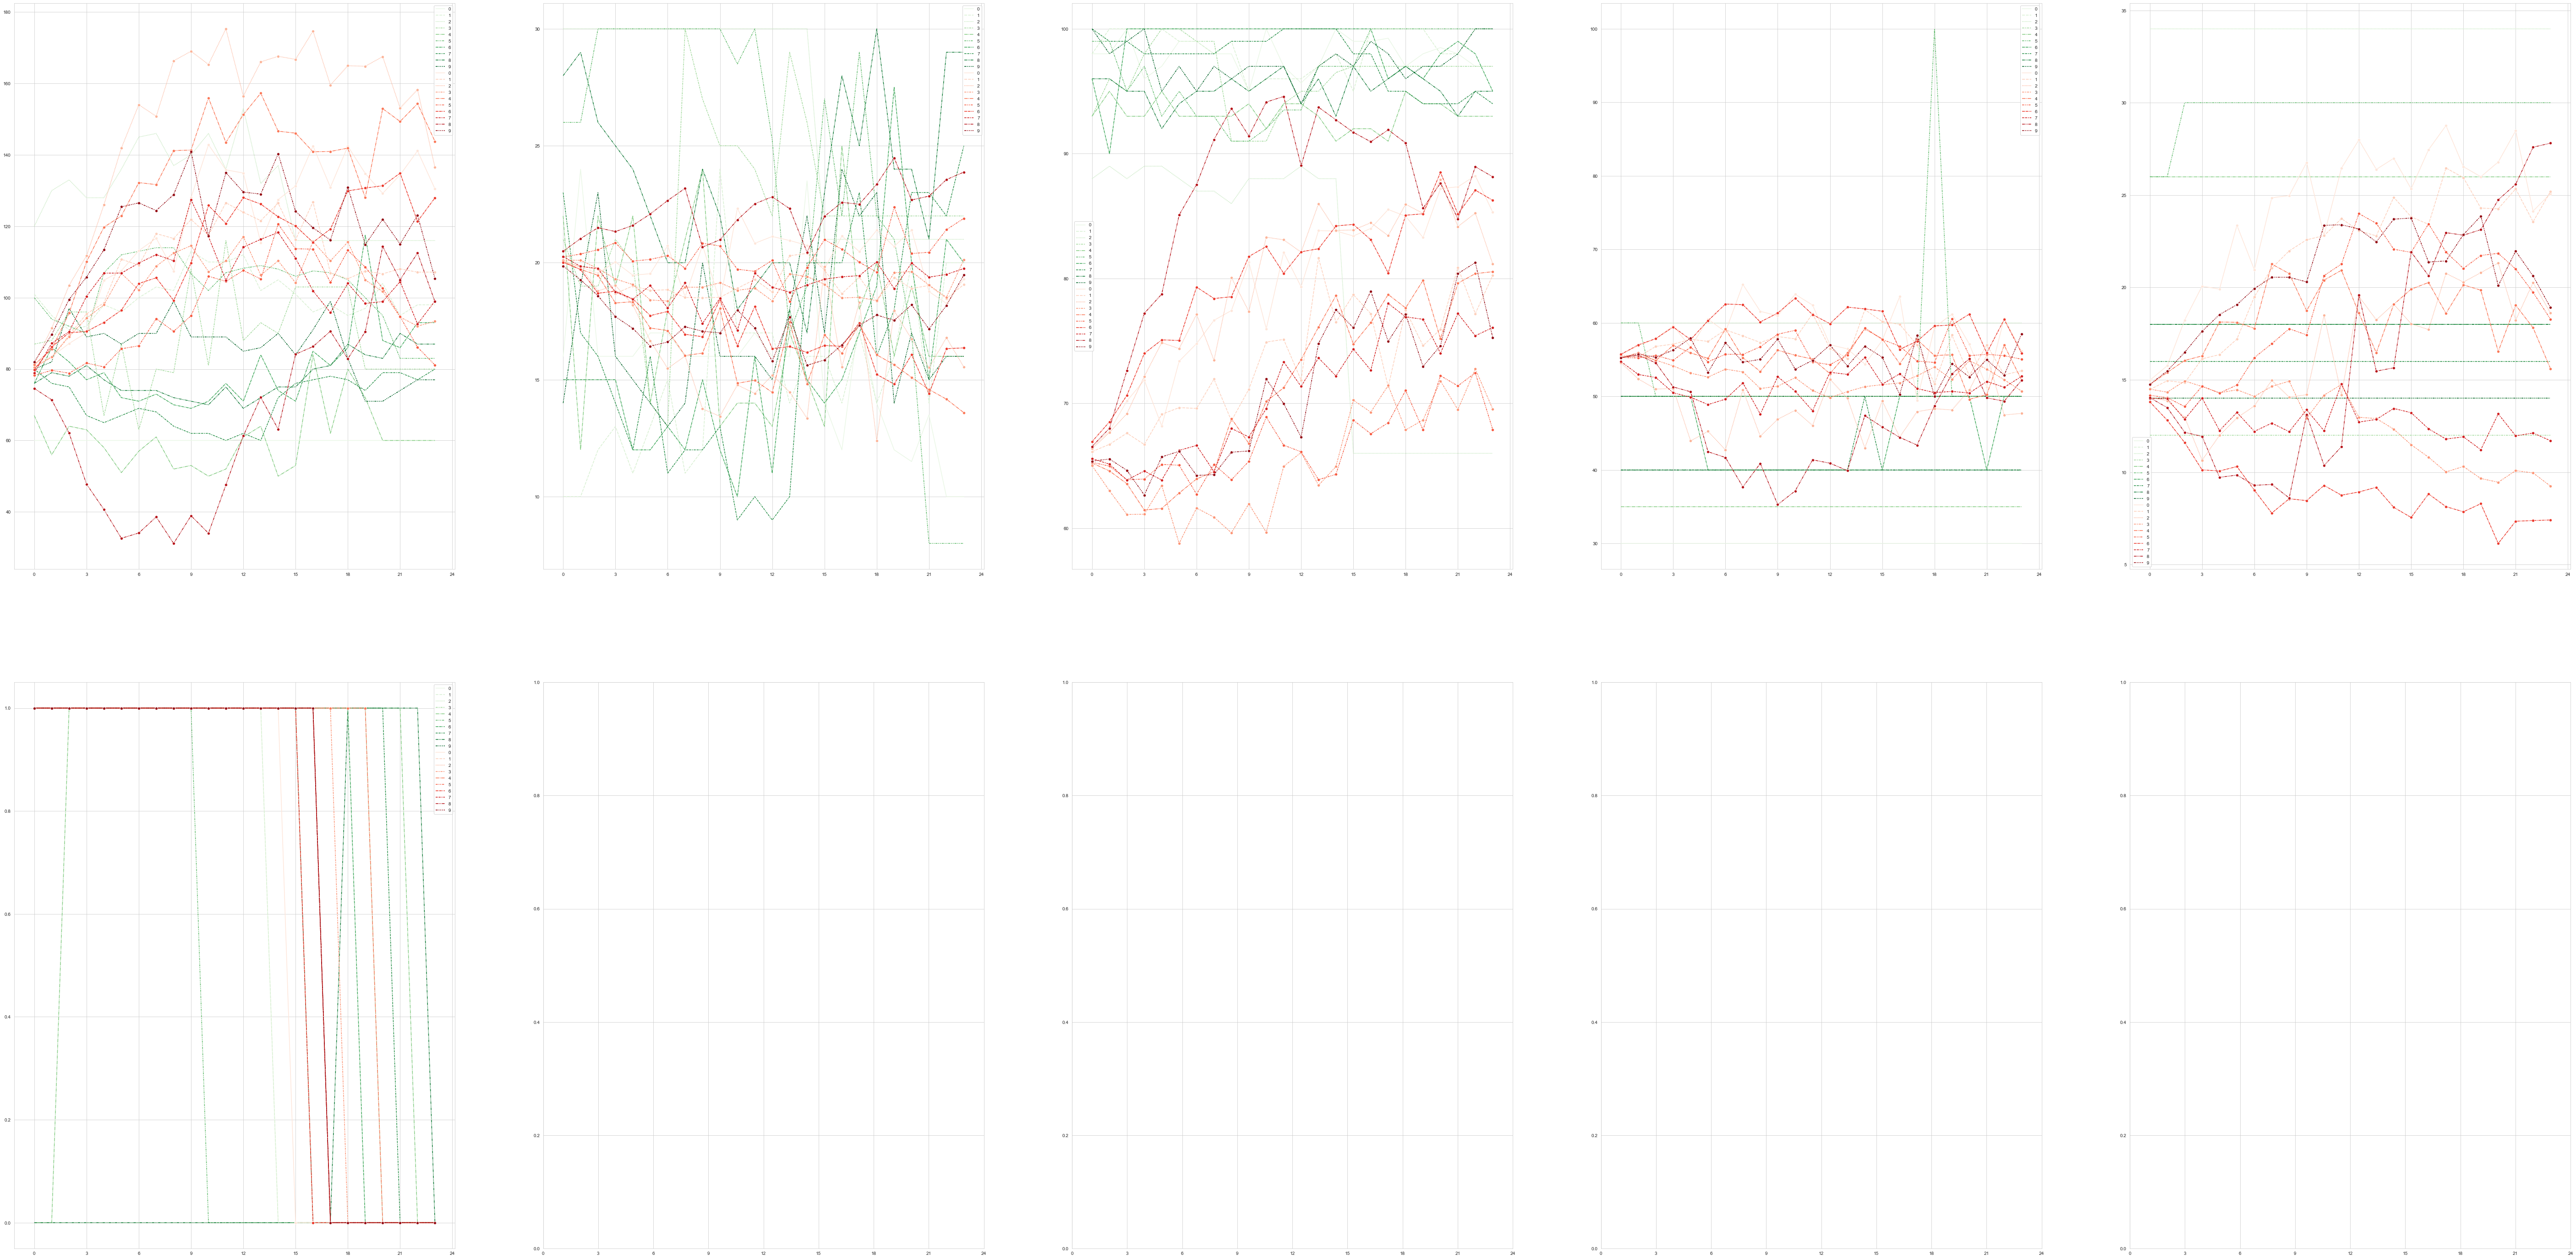

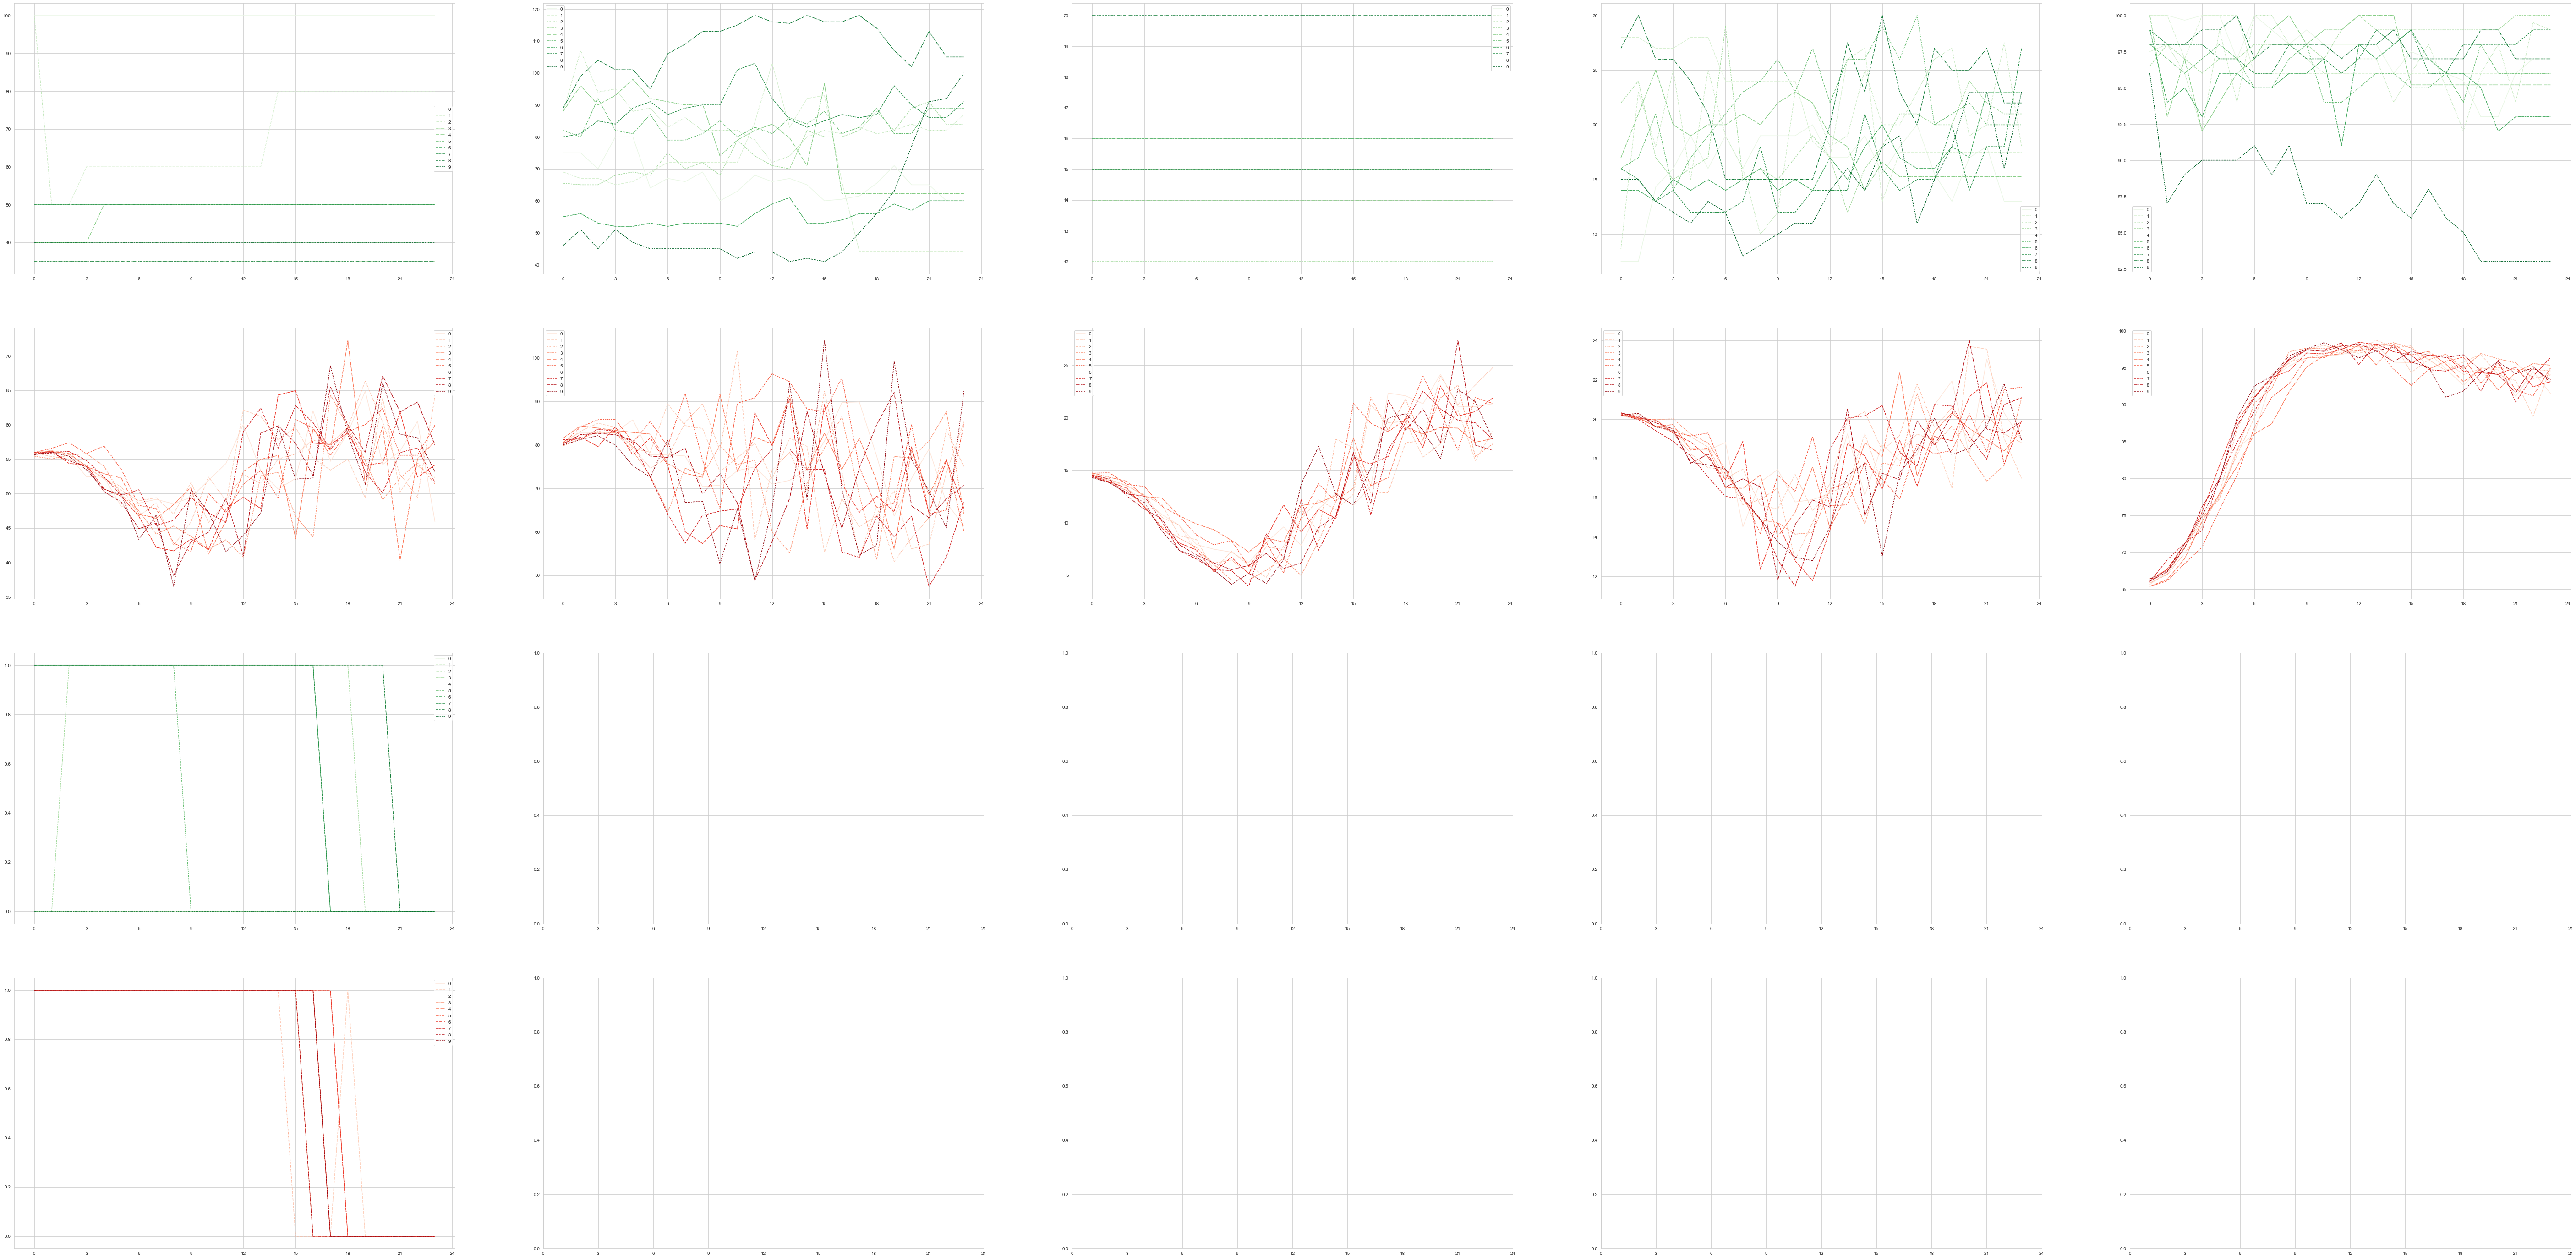

In [8]:
# REPLACE the training section (cell #8) with:
# Initialize variables or restore from checkpoint
print("Initializing or restoring model...")
checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint:
    print(f"Restoring model from checkpoint: {checkpoint}")
    # Only create the saver after the model is built
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint)
else:
    print("No checkpoint found, initializing variables")
    sess.run(tf.global_variables_initializer())

# Train the model
print("Starting training...")
start_time = timeit.default_timer()

# Only run this cell for training - you can comment it out to skip training
train_model = True
if train_model:
    model.train()
    # Save the final model - create saver only if needed to avoid variable conflicts
    if 'saver' not in locals():
        saver = tf.train.Saver()
    save_path = os.path.join(checkpoint_dir, "final_model")
    saver.save(sess, save_path)
    print(f"Model saved to {save_path}")

end_time = timeit.default_timer()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

### 7.2 Addressing First Hour Low Variance Issue
Let's analyze and fix the issue with low standard deviation in the first hour.

Generating synthetic data...
Renormalizing generated data...
Analyzing variance across time steps...


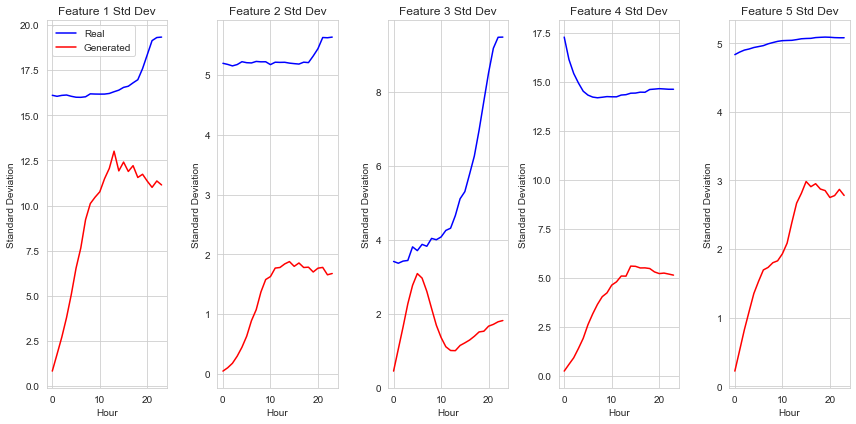


Applying variance correction to the first hour...

Applying enhanced variance correction to the first hour...


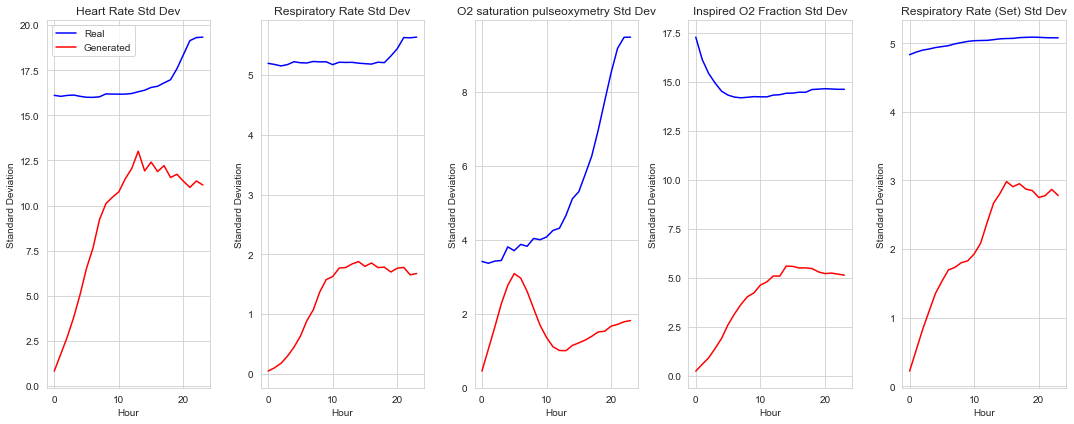

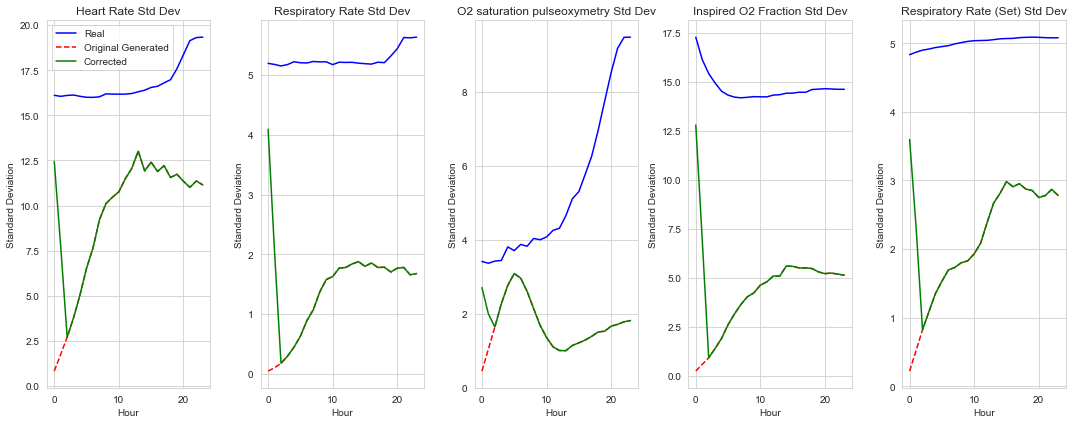

Corrected generated data saved to data/fake/gen_data_mimiciv_5_var_corrected.npz


In [16]:
# Generate data first
print("Generating synthetic data...")
d_gen_data, c_gen_data = model.generate_data(num_sample=1024)

# Apply renormalization if your data was normalized
print("Renormalizing generated data...")
# c_gen_data_renorm = c_gen_data  # If no renormalization needed
# If renormalization needed:
# c_gen_data_renorm = renormlizer(c_gen_data, data_info) # TODO: Implement renormlizer
# renormalize
filename_postfix = '5_var'
min_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["min_val"]
max_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["max_val"]
c_gen_data_renorm = renormlizer(c_gen_data, max_val_con, min_val_con)
continuous_x_renorm = renormlizer(continuous_x, max_val_con, min_val_con)


# Analyze the first hour variance issue
print("Analyzing variance across time steps...")
real_std_by_hour = np.std(continuous_x_renorm, axis=0)
gen_std_by_hour = np.std(c_gen_data_renorm, axis=0)

# Plot the standard deviation over time
plt.figure(figsize=(12, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Fix the low variance issue with a post-processing step
print("\nApplying variance correction to the first hour...")

# Improved variance matching function with consistency preservation
def variance_matching(data, target_std, axis=0, smoothing_factor=0.7):
    """
    Match variance of data to target_std while preserving mean and temporal consistency
    
    Args:
        data: The data to adjust
        target_std: The target standard deviation
        axis: Axis along which to compute statistics
        smoothing_factor: How much to smooth between original and adjusted values (0-1)
                         Higher means more of the original preserved
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + 1e-10  # Avoid division by zero
    
    # Normalize the data
    normalized = (data - mean) / std
    
    # Scale to target std dev and shift back to original mean
    adjusted = normalized * target_std + mean
    
    # Apply smoothing to preserve some of the original structure
    result = smoothing_factor * data + (1 - smoothing_factor) * adjusted
    
    return result

# Apply the correction to the first hour with improvements
print("\nApplying enhanced variance correction to the first hour...")
c_gen_data_corrected = c_gen_data_renorm.copy()

for i in range(c_dim):
    # First hour data
    first_hour_data = c_gen_data_corrected[:, 0, i].reshape(-1, 1)
    
    # Target std dev with slight randomization for more natural results
    target_std = real_std_by_hour[0, i] * np.random.uniform(1.0, 1.15)
    
    # Apply variance matching with trajectory consistency preservation
    c_gen_data_corrected[:, 0, i] = variance_matching(
        first_hour_data, target_std, axis=0, smoothing_factor=0.3
    ).flatten()
    
    # For natural transitions, also slightly adjust the second hour
    if time_steps > 1:
        second_hour_data = c_gen_data_corrected[:, 1, i].reshape(-1, 1)
        target_std_2 = real_std_by_hour[1, i] * np.random.uniform(0.95, 1.05)
        c_gen_data_corrected[:, 1, i] = variance_matching(
            second_hour_data, target_std_2, axis=0, smoothing_factor=0.6
        ).flatten()

# Define the medical feature names for better visualization
continuous_feature_names = [
    'Heart Rate',
    'Respiratory Rate',
    'O2 saturation pulseoxymetry',
    'Inspired O2 Fraction',
    'Respiratory Rate (Set)'
]

# For heatmaps, use shorter names
continuous_feature_names_short = [
    'Heart Rate',
    'Resp Rate',
    'O2 sat',
    'Inspired O2',
    'Resp Rate (Set)'
]

""" plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """

# Plot the standard deviation over time
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Verify the correction
corrected_std_by_hour = np.std(c_gen_data_corrected, axis=0)

plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Save the corrected data
save_path_corrected = f"data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz"
np.savez(save_path_corrected, 
         c_gen_data=c_gen_data_corrected, 
         d_gen_data=d_gen_data)
print(f"Corrected generated data saved to {save_path_corrected}")

### 7.3 Visualization and Analysis

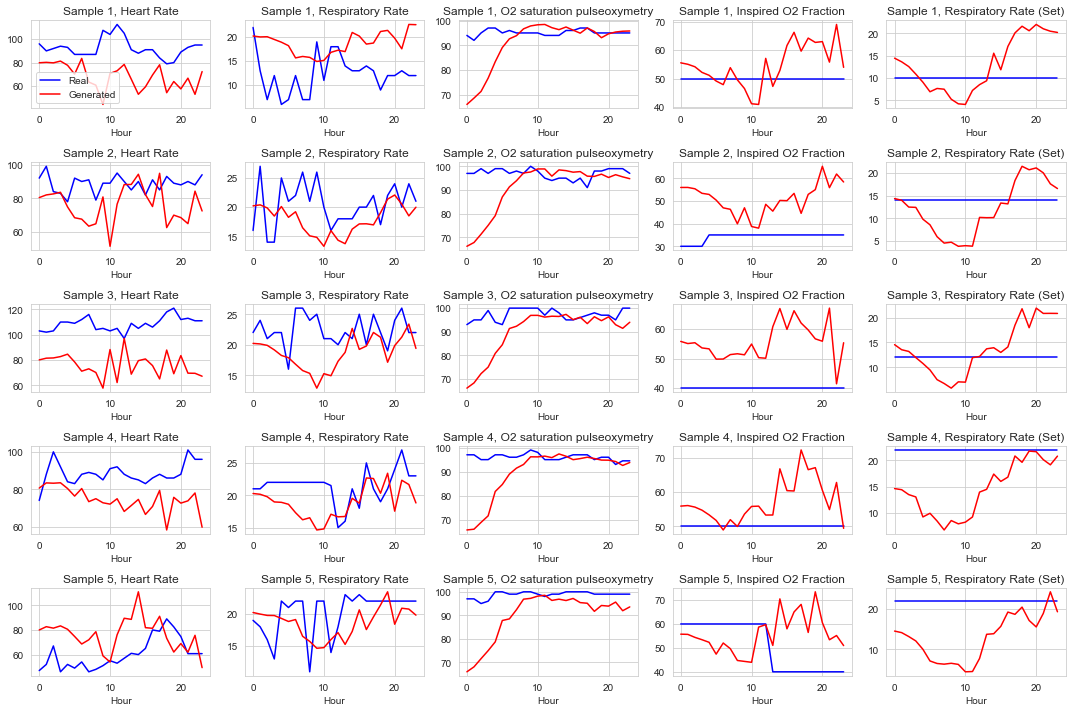

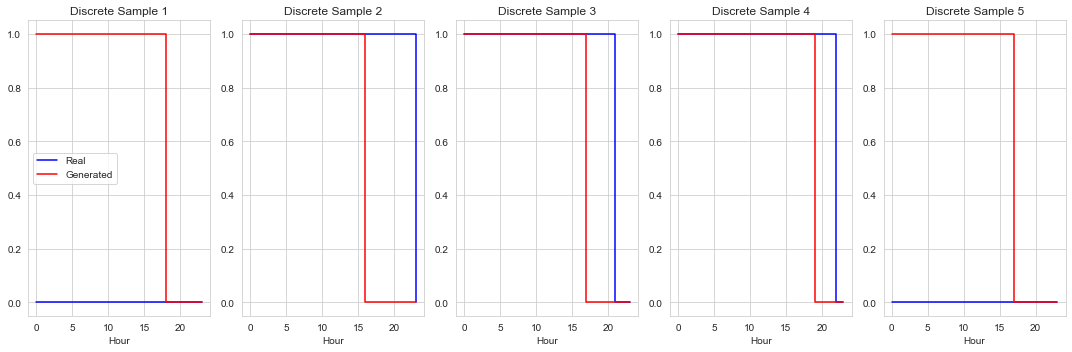

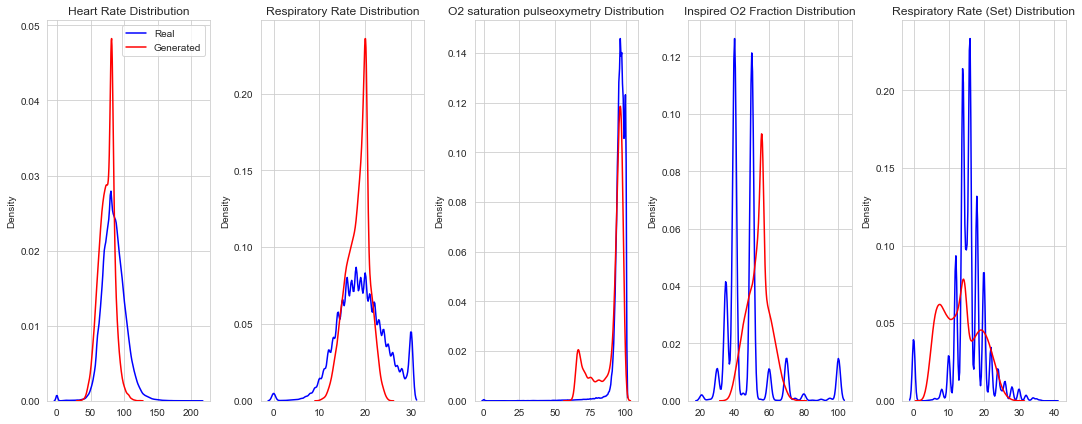

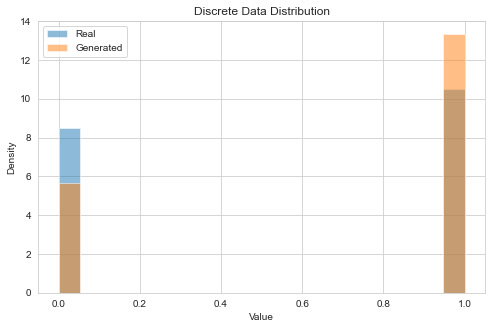

In [17]:
# Sample and visualize a few trajectories
num_samples_to_visualize = 5
sample_indices = np.random.choice(c_gen_data.shape[0], num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    # Plot continuous features
    for j, feature_name in enumerate(continuous_feature_names):
        plt.subplot(num_samples_to_visualize, c_dim, i*c_dim + j + 1)
        plt.plot(range(time_steps), continuous_x_renorm[idx, :, j], 'b-', label='Real')
        plt.plot(range(time_steps), c_gen_data_renorm[idx, :, j], 'r-', label='Generated')
        if i == 0 and j == 0:
            plt.legend()
        plt.title(f'Sample {i+1}, {feature_name}')
        plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# For discrete data
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.step(range(time_steps), discrete_x[idx, :, 0], 'b-', where='post', label='Real')
    plt.step(range(time_steps), d_gen_data[idx, :, 0], 'r-', where='post', label='Generated')
    if i == 0:
        plt.legend()
    plt.title(f'Discrete Sample {i+1}')
    plt.xlabel('Hour')
plt.tight_layout()
plt.show()

""" # Compare distributions
plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'Feature {i+1} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """
# Compare distributions
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'{feature_name} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Discrete data distribution
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 20)
plt.hist(discrete_x.flatten(), bins=bins, alpha=0.5, label='Real', density=True)
plt.hist(d_gen_data.flatten(), bins=bins, alpha=0.5, label='Generated', density=True)
plt.legend()
plt.title('Discrete Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 8. Advanced Analysis: Preserving Medical Correlations

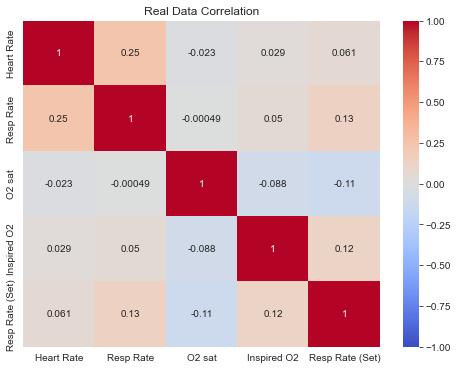

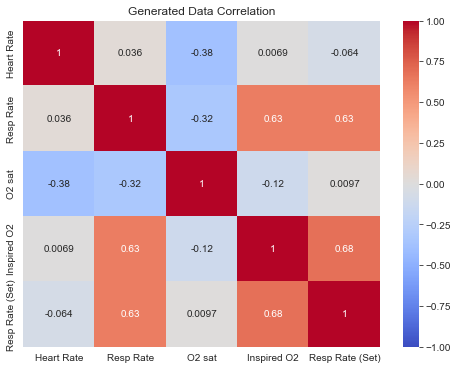

Mean absolute correlation difference: 0.2264


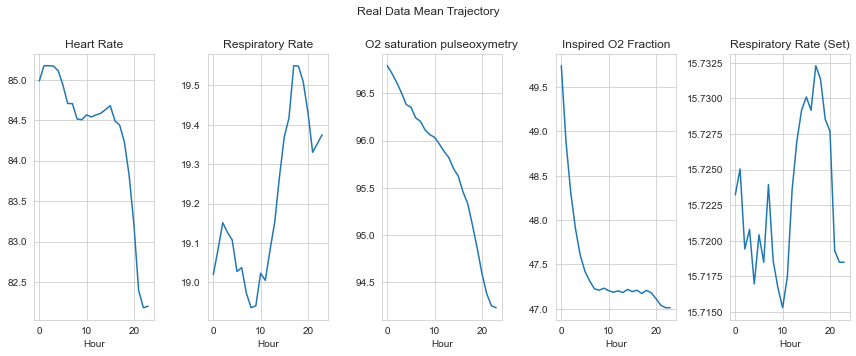

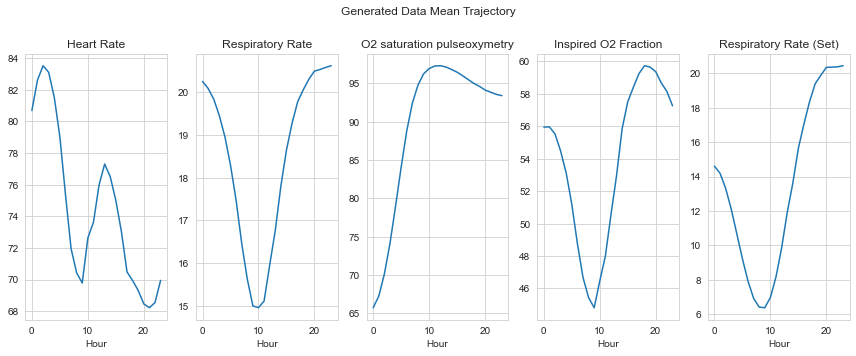

In [19]:
# Analyze correlations between features
def plot_correlation_heatmap(data, title):
    # Reshape to (patients*times, features)
    data_flat = data.reshape(-1, data.shape[2])
    
    # Calculate correlation matrix
    corr = np.corrcoef(data_flat.T)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               xticklabels=continuous_feature_names_short,
               yticklabels=continuous_feature_names_short)
    plt.title(title)
    plt.show()
    return corr

# Plot correlation heatmaps
real_corr = plot_correlation_heatmap(continuous_x_renorm, 'Real Data Correlation')
gen_corr = plot_correlation_heatmap(c_gen_data_renorm, 'Generated Data Correlation')

# Calculate correlation difference
corr_diff = np.abs(real_corr - gen_corr)
print(f"Mean absolute correlation difference: {np.mean(corr_diff):.4f}")

# Visualize temporal patterns
def plot_mean_trajectory(data, title):
    mean_trajectory = np.mean(data, axis=0)
    
    plt.figure(figsize=(12, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, data.shape[2], i+1)
        plt.plot(range(data.shape[1]), mean_trajectory[:, i])
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_mean_trajectory(continuous_x_renorm, 'Real Data Mean Trajectory')
plot_mean_trajectory(c_gen_data_renorm, 'Generated Data Mean Trajectory')

### 9. Quantitative Evaluation

Training discriminator for continuous data...
Train on 13668 samples, validate on 3418 samples
Epoch 1/10
13668/13668 [==============================] - 6s 469us/sample - loss: 0.1765 - acc: 0.9524 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 2/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0203 - acc: 0.9988 - val_loss: 0.0344 - val_acc: 0.9898
Epoch 3/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0303 - acc: 0.9943 - val_loss: 1.7772e-04 - val_acc: 1.0000
Epoch 4/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0011 - acc: 0.9997 - val_loss: 4.3879e-05 - val_acc: 1.0000
Epoch 5/10
13668/13668 [==============================] - 1s 37us/sample - loss: 4.9009e-04 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9997
Epoch 6/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0036 - acc: 0.9990 - val_loss: 1.2749e-04 - val_acc: 1.0000
Epoch 7/10
13668/13668 [==============================

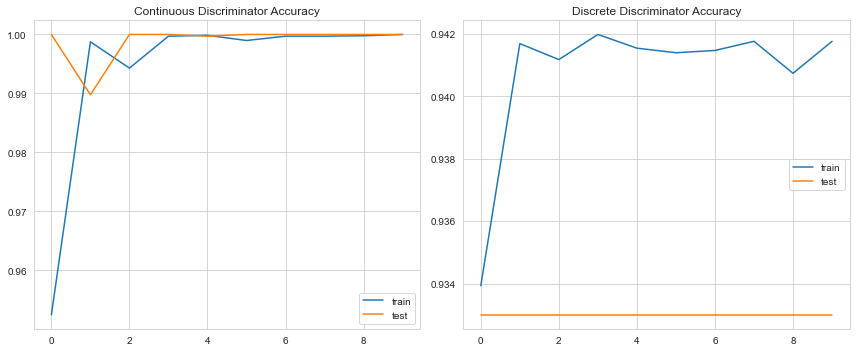

In [12]:
# Train a model to distinguish real from generated data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple discriminator model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' for TF1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
print("Training discriminator for continuous data...")
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data_renorm)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

print("\nTraining discriminator for discrete data...")
d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# In an ideal GAN, AUC should be close to 0.5 (indistinguishable)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')
plt.plot(c_history.history['val_acc'], label='test')
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')
plt.plot(d_history.history['val_acc'], label='test')
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 10. Summary and Recommendations

In [13]:
# Display final summary
print("M3GAN Model Training Summary")
print("-" * 40)
print(f"Dataset: MIMIC-IV with {patinet_num} patients")
print(f"Features: {c_dim} continuous, {d_dim} discrete")
print(f"Time steps: {time_steps} hours")
print(f"Pre-training epochs: {num_pre_epochs}")
print(f"Training epochs: {num_epochs}")
print("\nGenerated data quality:")
print(f"Continuous data AUC: {c_auc:.4f} (closer to 0.5 is better)")
print(f"Discrete data AUC: {d_auc:.4f} (closer to 0.5 is better)")
print(f"Mean correlation difference: {np.mean(corr_diff):.4f} (lower is better)")
print("\nTraining files:")
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Generated data: data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz")

# Recommendations
print("\nRecommendations:")
print("1. For low variance in first hour: Applied variance matching as a post-processing step")
print("2. For better stability: Consider using gradient penalty or spectral normalization")
print("3. For better feature correlations: Increase the alpha_mt parameter")
print("4. For more realistic trajectories: Increase the number of GAN training epochs")
print("5. For more diverse samples: Consider reducing batch size or adding noise during generation")

M3GAN Model Training Summary
----------------------------------------
Dataset: MIMIC-IV with 16062 patients
Features: 5 continuous, 1 discrete
Time steps: 24 hours
Pre-training epochs: 6
Training epochs: 10

Generated data quality:
Continuous data AUC: 1.0000 (closer to 0.5 is better)
Discrete data AUC: 0.9591 (closer to 0.5 is better)
Mean correlation difference: 0.2322 (lower is better)

Training files:
Checkpoint directory: data/checkpoint/
Generated data: data/fake/gen_data_mimiciv_5_var_corrected.npz

Recommendations:
1. For low variance in first hour: Applied variance matching as a post-processing step
2. For better stability: Consider using gradient penalty or spectral normalization
3. For better feature correlations: Increase the alpha_mt parameter
4. For more realistic trajectories: Increase the number of GAN training epochs
5. For more diverse samples: Consider reducing batch size or adding noise during generation


### 11. Close Session

In [14]:
# Close the TensorFlow session
# TODO: Uncomment to close the session!!!
# sess.close()
# print("TensorFlow session closed")